In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import random
from sklearn.cluster import KMeans
from scipy.sparse import csc_matrix,csr_matrix
import torchvision
import torchvision.transforms as transforms
import warnings
import torchvision.models as models
warnings.filterwarnings('ignore')
%matplotlib notebook

## MNIST Teacher Network

In [2]:
trainSetMNIST=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))
testSetMNIST=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))

In [3]:
trainLoaderMNIST=DataLoader(dataset=trainSetMNIST,batch_size=4,shuffle=True)
testLoaderMNIST=DataLoader(dataset=testSetMNIST,batch_size=1,shuffle=True)

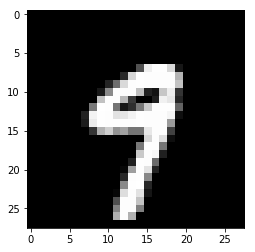

In [4]:
example=iter(testLoaderMNIST)
image,label=example.next()
#print(image.shape,label.shape)
plt.imshow(image[0][0],cmap='gray')
tempExample=image
tempLabel=label

In [3]:
trainLoaderMNIST=DataLoader(dataset=trainSetMNIST,batch_size=4,shuffle=True)
testLoaderMNIST=DataLoader(dataset=testSetMNIST,batch_size=10000,shuffle=True)

In [10]:
use_cuda=True
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,20,5,1)
        #self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(20,50,5,1)
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2=nn.Dropout2d(0.5)
        self.fc1=nn.Linear(800,500)
        self.fc2=nn.Linear(500,10)
        #self.fc3=nn.Linear(128,10)
    def forward(self,image):
        x=F.relu(self.conv1(image))
        x=F.max_pool2d(x,2,2)
        x=F.relu(self.conv2(x))
        x=F.max_pool2d(x,2)
        x = x.view(x.size(0), -1)
        
        x=F.relu(self.fc1(x))
        
        x=self.fc2(x)
        return x
Teacher=ConvNet()
if use_cuda and torch.cuda.is_available():
    Teacher.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(Teacher.parameters(),lr=0.001,momentum=0.9)



In [11]:
def train():
    Teacher.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    runninglosstotal=0.0
    for i,(image,labels) in enumerate(trainLoaderMNIST):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=Teacher(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        runninglosstotal+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return runninglosstotal/len(trainLoaderMNIST),(correct/total)*100




In [12]:
def testMNIST(testLoaderMNIST):
    with torch.no_grad():
        Teacher.eval()
        correct=0
        total=0
        runningloss=0
        for i,(image,labels) in enumerate(testLoaderMNIST):
            if use_cuda and torch.cuda.is_available():
                image=image.cuda()
                labels=labels.cuda()
            prediction=Teacher(image)
            loss=criterion(prediction,labels)
            runningloss+=loss.item()
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=labels.shape[0]
    return runningLoss/len(testLoaderMNIST),(correct/total)*100

In [13]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=train()
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.3049
epoch 1/10,batch 10000,loss=0.0830
epoch 1/10,batch 15000,loss=0.0601
epoch 2/10,batch 5000,loss=0.0421
epoch 2/10,batch 10000,loss=0.0425
epoch 2/10,batch 15000,loss=0.0411
epoch 3/10,batch 5000,loss=0.0289
epoch 3/10,batch 10000,loss=0.0289
epoch 3/10,batch 15000,loss=0.0292
epoch 4/10,batch 5000,loss=0.0179
epoch 4/10,batch 10000,loss=0.0206
epoch 4/10,batch 15000,loss=0.0198
epoch 5/10,batch 5000,loss=0.0162
epoch 5/10,batch 10000,loss=0.0151
epoch 5/10,batch 15000,loss=0.0171
epoch 6/10,batch 5000,loss=0.0068
epoch 6/10,batch 10000,loss=0.0129
epoch 6/10,batch 15000,loss=0.0140
epoch 7/10,batch 5000,loss=0.0075
epoch 7/10,batch 10000,loss=0.0098
epoch 7/10,batch 15000,loss=0.0108
epoch 8/10,batch 5000,loss=0.0056
epoch 8/10,batch 10000,loss=0.0062
epoch 8/10,batch 15000,loss=0.0064
epoch 9/10,batch 5000,loss=0.0051
epoch 9/10,batch 10000,loss=0.0050
epoch 9/10,batch 15000,loss=0.0048
epoch 10/10,batch 5000,loss=0.0034
epoch 10/10,batch 10000,loss=

In [16]:
temp=[1,7,10,15,20,30]
def softmaxFunction(weight):
    weight=weight.cpu()
    return np.exp(weight)/np.exp(weight).sum()
values=list()
for value in temp:
    with torch.no_grad():
        if use_cuda and torch.cuda.is_available():
            tempExample=tempExample.cuda()
            tempLabel=tempLabel.cuda()
        #print(tempExample.shape)
        prediction=Teacher(tempExample)
        
        softmaxOutput=softmaxFunction(prediction/value)
        values.append(softmaxOutput)

In [17]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=99.87666666666667
Test accuracy=99.27


In [18]:
pytorch_total_params = sum(p.numel() for p in Teacher.parameters())
print(f'Total number of parameters of Teacher model is {pytorch_total_params}')
print(f'Total space occupied by the model is {pytorch_total_params*4} bytes')

Total number of parameters of Teacher model is 431080
Total space occupied by the model is 1724320 bytes


In [19]:
temp=[1,7,10,15,20,30]
def softmaxFunction(weight):
    weight=weight.cpu()
    return np.exp(weight)/np.exp(weight).sum()
values=list()
for value in temp:
    with torch.no_grad():
        if use_cuda and torch.cuda.is_available():
            tempExample=tempExample.cuda()
            tempLabel=tempLabel.cuda()
        #print(tempExample.shape)
        prediction=Teacher(tempExample)
        
        softmaxOutput=softmaxFunction(prediction/value)
        values.append(softmaxOutput)

<IPython.core.display.Javascript object>


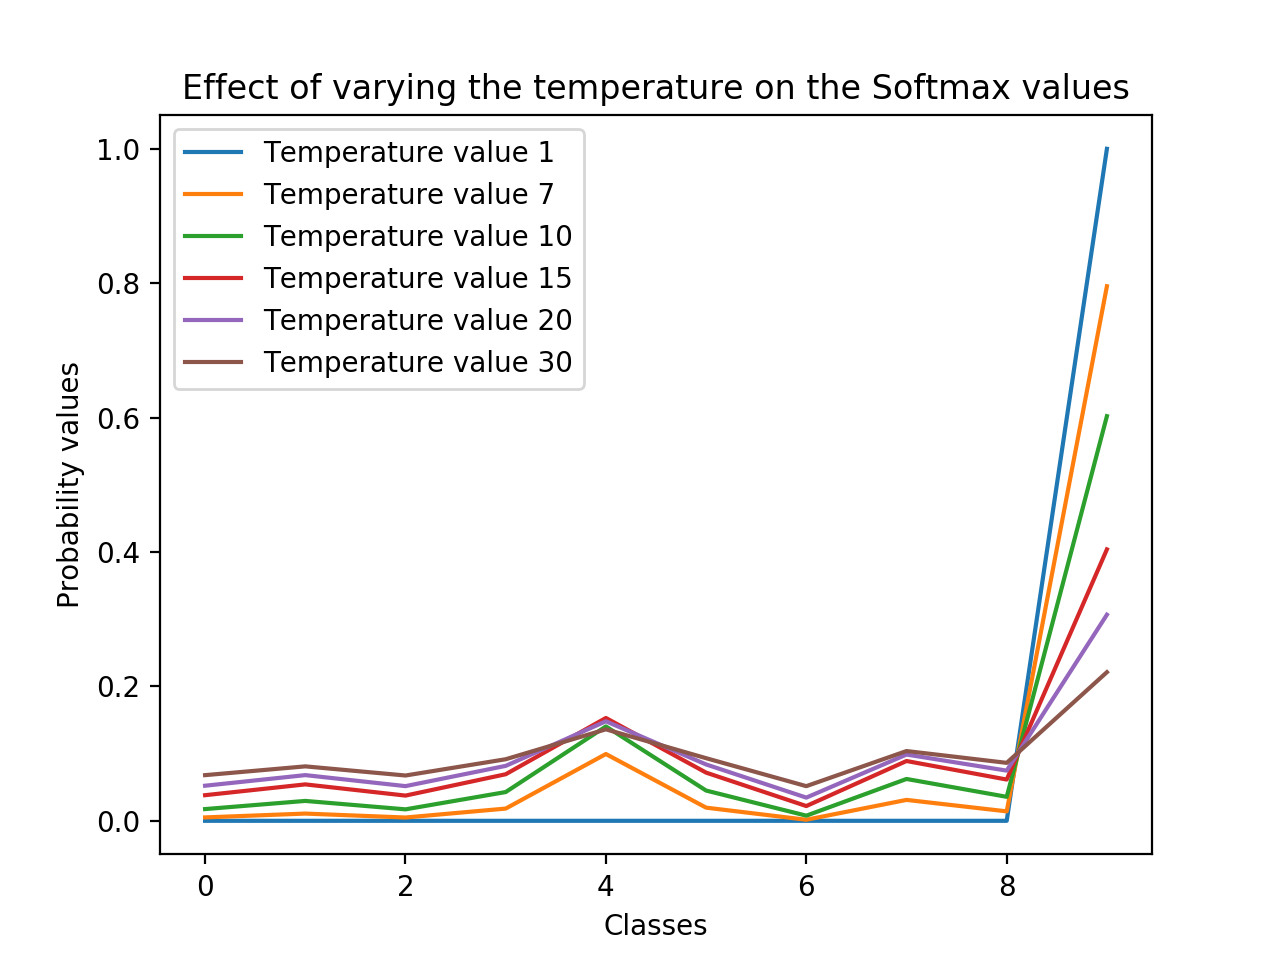

In [20]:
%matplotlib notebook
x=[i for i in range(10)]
for i in range(len(values)):
    plt.figure(1)
    plt.plot(x,values[i].numpy()[0,:],label='Temperature value {}'.format(temp[i]))
    plt.legend()
    plt.xlabel('Classes')
    plt.ylabel('Probability values')
    plt.title('Effect of varying the temperature on the Softmax values')

<IPython.core.display.Javascript object>


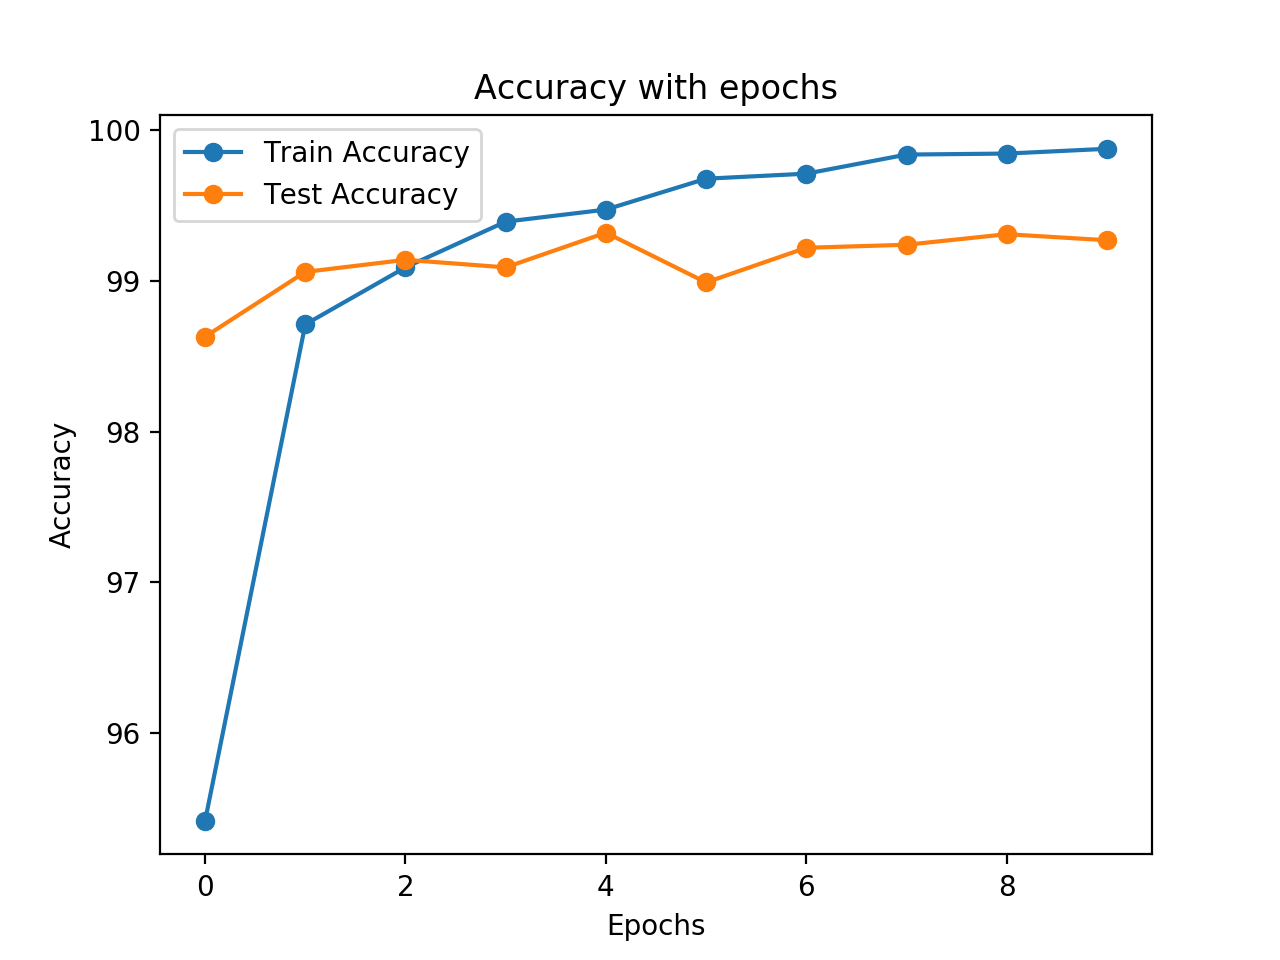

<IPython.core.display.Javascript object>


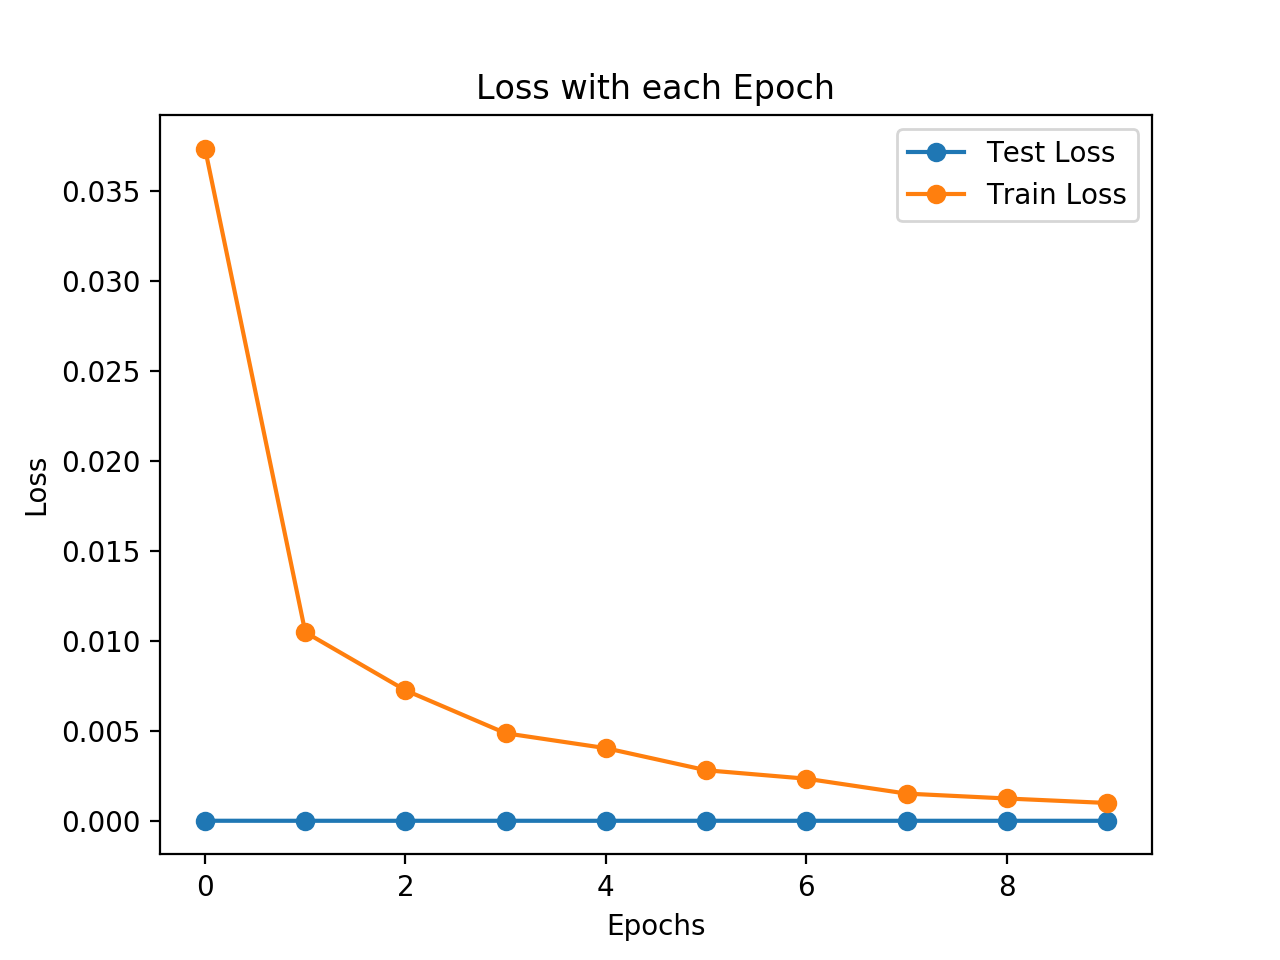

In [21]:
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy with epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with each Epoch')
plt.legend()

## MNIST Student Network

In [22]:
temp=7
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,32)
        #self.fc2=nn.Linear(800,800)
        self.fc3=nn.Linear(32,10)
        #self.fc1.weight_orig=self.fc1.weight
        #del self.fc1.weight
        #self.fc2.weight_orig=self.fc2.weight
        #del self.fc2.weight
        #self.fc3.weight_orig=self.fc3.weight
        #del self.fc3.weight
    def forward(self,data):
        x=data.view(-1,28*28)
        #self.fc1.weight=getQuantizedWeights(self.fc1.weight_orig)
        #print(self.fc1.weight)
        x=F.relu(self.fc1(x))
        #self.fc2.weight=getQuantizedWeights(self.fc2.weight_orig)
        #print(self.fc2.weight)
        #x=F.relu(self.fc2(x))
        #self.fc3.weight=getQuantizedWeights(self.fc3.weight_orig)
        x=self.fc3(x)
        return x
def knowledgedistillationloss(outputs,labels,weightTeacher,alpha):
    return nn.KLDivLoss()(F.log_softmax(outputs/temp,dim=1),F.softmax(weightTeacher/temp,dim=1))+alpha*F.cross_entropy(outputs,labels)
'''def knowledgedistillationloss(studentLogits,teacherLogits,minibatchsize):
    return (1/2*minibatchsize)*(studentLogits-teacherLogits)'''
modelStudent=Student()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStudent.cuda()
optimizer=torch.optim.SGD(modelStudent.parameters(),lr=0.01,momentum=0.9)
def trainStudent(trainLoader):
    modelStudent.train()
    Teacher.eval()
    runningloss=0.0
    correct=0
    total=0
    totalLoss=0.0
    for i,(data,labels) in enumerate(trainLoader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=modelStudent(data)
        weightTeacher=Teacher(data)
        weightTeacher=weightTeacher.detach()
        loss=knowledgedistillationloss(predicted,labels,weightTeacher,0.1)
        #print(weightTeacher.shape,predicted.shape,labels.shape)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        #modelStudent.fc1.weight.grad_orig=modelStudent.fc1.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc2.weight.grad_orig=modelStudent.fc2.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc3.weight.grad_orig=modelStudent.fc3.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc1.weight.grad=getQuantizedWeights(modelStudent.fc1.weight.grad_orig)
        #modelStudent.fc2.weight.grad=getQuantizedWeights(modelStudent.fc2.weight.grad_orig)
        #modelStudent.fc3.weight.grad=getQuantizedWeights(modelStudent.fc3.weight.grad_orig)
        optimizer.step()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        totalLoss+=loss.item()
            #print(loss.item())
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return totalLoss/len(trainLoader),(correct/total)*100
            
                

In [23]:
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        runningLoss=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=Teacher(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
            runningLoss+=loss.item()
    return runningLoss/len(testLoader),(correct/total)*100

In [24]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=trainStudent(trainLoaderMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testStudent(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.1125
epoch 1/10,batch 10000,loss=0.0735
epoch 1/10,batch 15000,loss=0.0605
epoch 2/10,batch 5000,loss=0.0499
epoch 2/10,batch 10000,loss=0.0476
epoch 2/10,batch 15000,loss=0.0442
epoch 3/10,batch 5000,loss=0.0399
epoch 3/10,batch 10000,loss=0.0379
epoch 3/10,batch 15000,loss=0.0375
epoch 4/10,batch 5000,loss=0.0344
epoch 4/10,batch 10000,loss=0.0344
epoch 4/10,batch 15000,loss=0.0334
epoch 5/10,batch 5000,loss=0.0301
epoch 5/10,batch 10000,loss=0.0302
epoch 5/10,batch 15000,loss=0.0315
epoch 6/10,batch 5000,loss=0.0294
epoch 6/10,batch 10000,loss=0.0283
epoch 6/10,batch 15000,loss=0.0286
epoch 7/10,batch 5000,loss=0.0274
epoch 7/10,batch 10000,loss=0.0265
epoch 7/10,batch 15000,loss=0.0280
epoch 8/10,batch 5000,loss=0.0274
epoch 8/10,batch 10000,loss=0.0267
epoch 8/10,batch 15000,loss=0.0255
epoch 9/10,batch 5000,loss=0.0247
epoch 9/10,batch 10000,loss=0.0254
epoch 9/10,batch 15000,loss=0.0253
epoch 10/10,batch 5000,loss=0.0231
epoch 10/10,batch 10000,loss=

In [25]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=96.67666666666666
Test accuracy=96.33


<IPython.core.display.Javascript object>


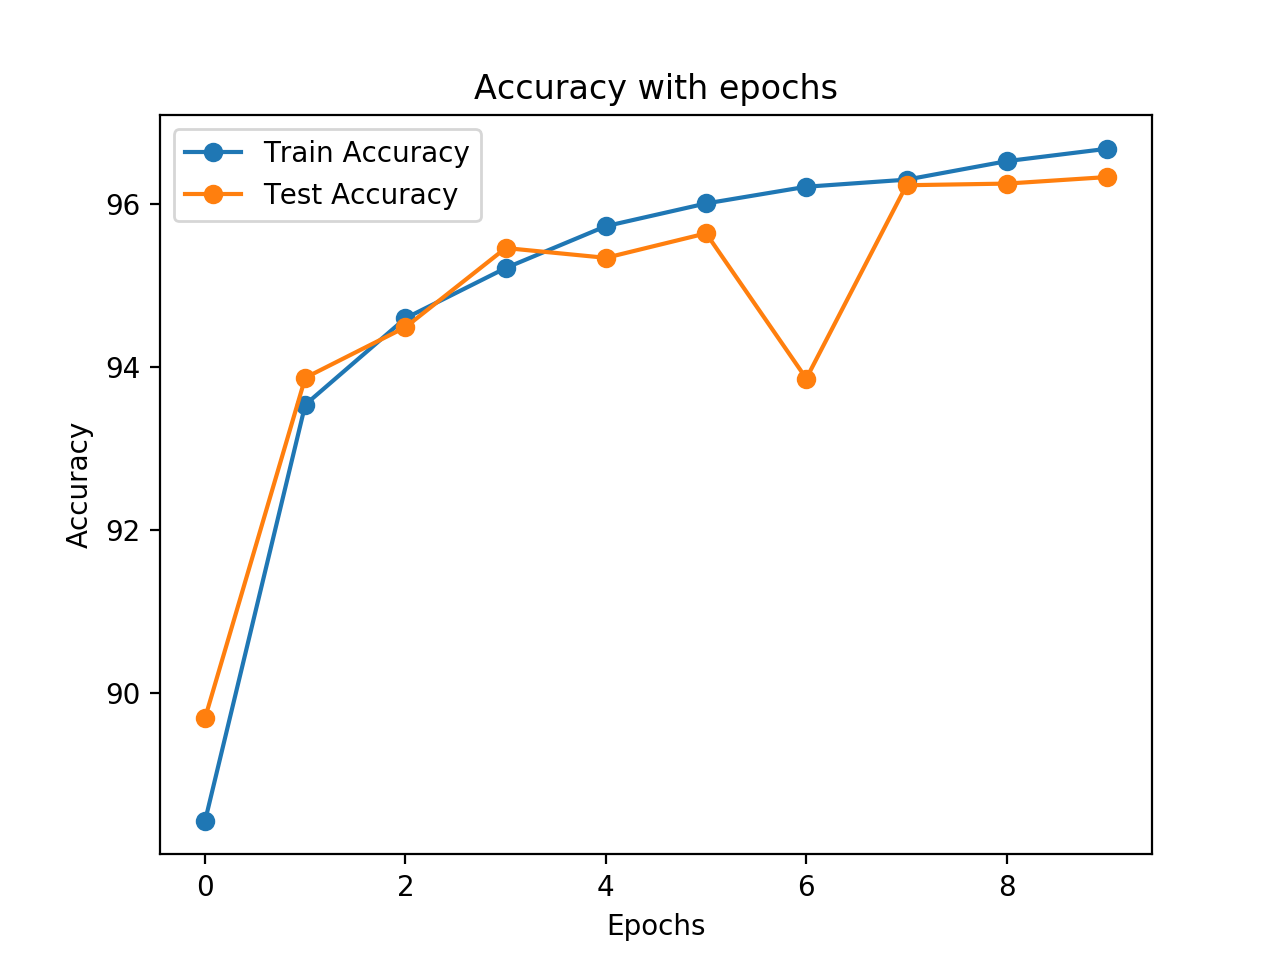

<IPython.core.display.Javascript object>


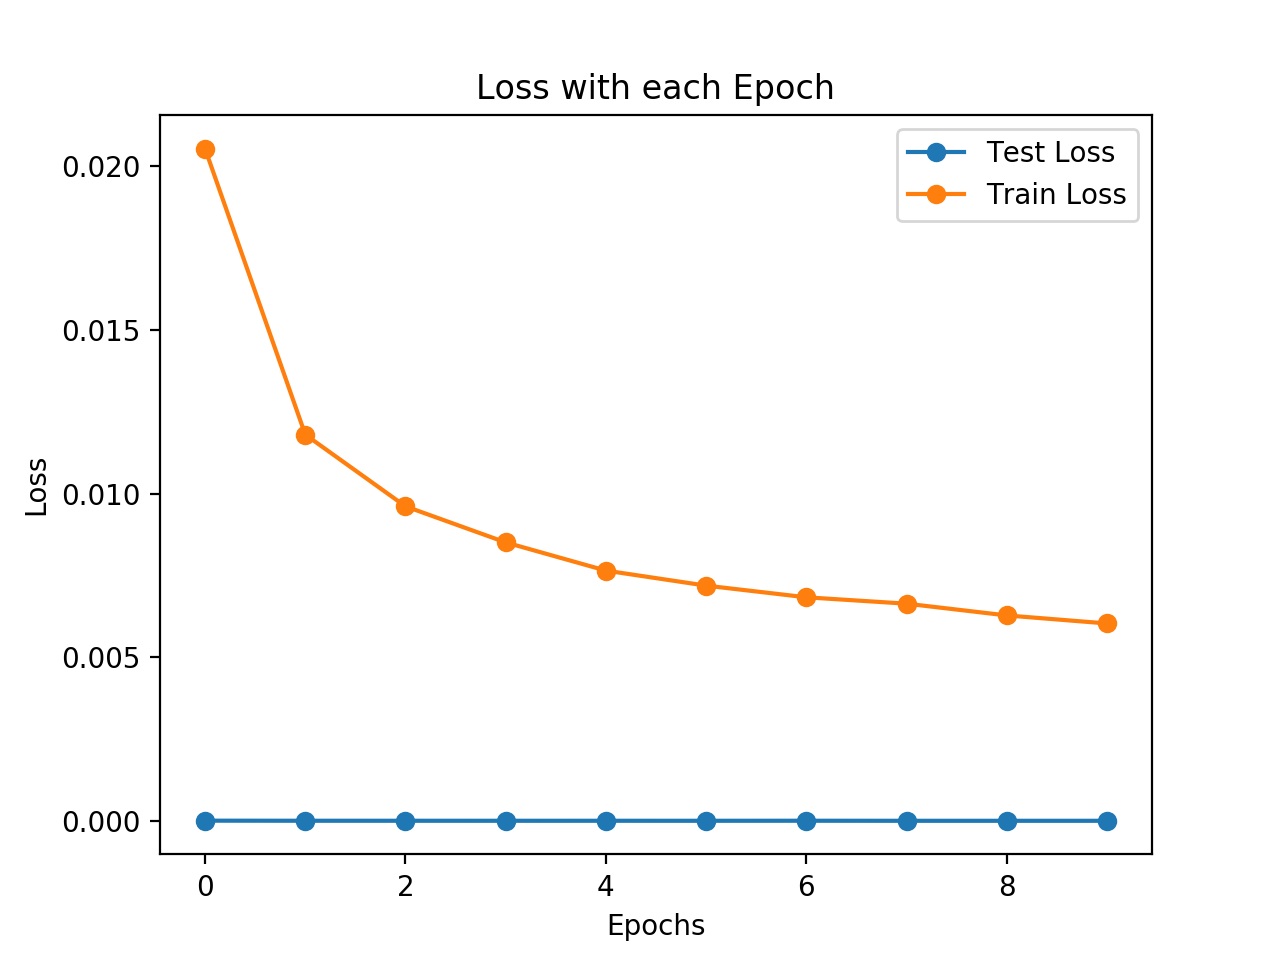

In [26]:
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy with epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with each Epoch')
plt.legend()

In [28]:
torch.save(modelStudent.state_dict(),'./mnist_student.pth')

In [29]:
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'The total number of Parameteres are {pytorch_total_params}')
print(f'Total size of the file is {pytorch_total_params*4} bytes')

The total number of Parameteres are 25450
Total size of the file is 101800 bytes


In [30]:
def getQuantizedWeights(weight,nClusters=10):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0]*weightCopy.shape[1],-1)).reshape(weightCopy.shape[0],weightCopy.shape[1])
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            for j in range(weight.shape[1]):
                weight[i][j]=torch.from_numpy(kmeans.cluster_centers_[labels[i][j]])
        #print(weight)
    return weight
modelStudent.fc1.weight_orig=modelStudent.fc1.weight
#print(modelStudent.fc1.weight_orig)
#del modelStudent.fc1.weight
#modelStudent.fc2.weight_orig=modelStudent.fc2.weight
#del modelStudent.fc2.weight
modelStudent.fc3.weight_orig=modelStudent.fc3.weight
#del modelStudent.fc3.weight
modelStudent.fc1.weight=getQuantizedWeights(modelStudent.fc1.weight_orig,10)
#modelStudent.fc2.weight=getQuantizedWeights(modelStudent.fc2.weight_orig,10)
modelStudent.fc3.weight=getQuantizedWeights(modelStudent.fc3.weight_orig,10)

In [31]:
def getQuantizedWeightsBias(weight,nClusters=4):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        #print(weightCopy.view(weightCopy.shape[0],-1).shape)
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0],-1))
        #print(labels)
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            weight[i]=torch.from_numpy(kmeans.cluster_centers_[labels[i]])
    return weight
modelStudent.fc1.bias_orig=modelStudent.fc1.bias
#print(modelStudent.fc1.bias_orig)
#del modelStudent.fc1.bias
#modelStudent.fc2.bias_orig=modelStudent.fc2.bias
#del modelStudent.fc2.weight
modelStudent.fc3.bias_orig=modelStudent.fc3.bias
#del modelStudent.fc3.bias
#print(getQuantizedWeightsBias(modelStudent.fc1.bias_orig,4))
modelStudent.fc1.bias=getQuantizedWeightsBias(modelStudent.fc1.bias_orig,4)
#modelStudent.fc2.bias=getQuantizedWeightsBias(modelStudent.fc2.bias_orig,4)
modelStudent.fc3.bias=getQuantizedWeightsBias(modelStudent.fc3.bias_orig,4)
#print(modelStudent.fc1.bias)

In [32]:
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=Teacher(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=9564.0,accuracy=95.64


In [33]:
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'The total number of Parameters are {pytorch_total_params}')
additionalParameters=(32*10*2)+(32*4*2)
print(f'Total size of the file is {(pytorch_total_params/2)+(additionalParameters/8)} bytes')

The total number of Parameters are 25450
Total size of the file is 13621.0 bytes


## Standalone Student Network

In [4]:
class StandaloneStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,32)
        
        self.fc3=nn.Linear(32,10)
       
    def forward(self,data):
        x=data.view(-1,28*28)

        x=F.relu(self.fc1(x))
        
        x=self.fc3(x)
        return x
modelStandaloneStudent=StandaloneStudent()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStandaloneStudent.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(modelStandaloneStudent.parameters(),lr=0.01,momentum=0.9)
def train(trainLoaderMNIST):
    modelStandaloneStudent.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    runninglosstotal=0.0
    for i,(image,labels) in enumerate(trainLoaderMNIST):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=modelStandaloneStudent(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        runninglosstotal+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return runninglosstotal/len(trainLoaderMNIST),(correct/total)*100

In [5]:
def testMNIST(testLoaderMNIST):
    with torch.no_grad():
        modelStandaloneStudent.eval()
        correct=0
        total=0
        runningLoss=0
        for i,(image,labels) in enumerate(testLoaderMNIST):
            if use_cuda and torch.cuda.is_available():
                image=image.cuda()
                labels=labels.cuda()
            prediction=modelStandaloneStudent(image)
            loss=criterion(prediction,labels)
            runningLoss+=loss.item()
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=labels.shape[0]
    return runningLoss/len(testLoaderMNIST),(correct/total)*100

In [6]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=2.0574
epoch 1/10,batch 10000,loss=2.0523
epoch 1/10,batch 15000,loss=2.0424
epoch 2/10,batch 5000,loss=2.0607
epoch 2/10,batch 10000,loss=2.0520
epoch 2/10,batch 15000,loss=2.0704
epoch 3/10,batch 5000,loss=2.0444
epoch 3/10,batch 10000,loss=2.1418
epoch 3/10,batch 15000,loss=2.0576
epoch 4/10,batch 5000,loss=1.9485
epoch 4/10,batch 10000,loss=1.9208
epoch 4/10,batch 15000,loss=1.9249
epoch 5/10,batch 5000,loss=1.9286
epoch 5/10,batch 10000,loss=1.8383
epoch 5/10,batch 15000,loss=1.7740
epoch 6/10,batch 5000,loss=1.6959
epoch 6/10,batch 10000,loss=1.7481
epoch 6/10,batch 15000,loss=1.7766
epoch 7/10,batch 5000,loss=1.7865
epoch 7/10,batch 10000,loss=1.7830
epoch 7/10,batch 15000,loss=1.7933
epoch 8/10,batch 5000,loss=1.7499
epoch 8/10,batch 10000,loss=1.7600
epoch 8/10,batch 15000,loss=1.8756
epoch 9/10,batch 5000,loss=1.8879
epoch 9/10,batch 10000,loss=1.9264
epoch 9/10,batch 15000,loss=1.9363
epoch 10/10,batch 5000,loss=1.9162
epoch 10/10,batch 10000,loss=

In [7]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=26.023333333333333
Test accuracy=25.009999999999998


## Fashion MNIST Teacher Network

In [2]:
trainSetFashionMNIST=torchvision.datasets.FashionMNIST(root='./data',train=True,transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))]),download=True)
testSetFashionMNIST=torchvision.datasets.FashionMNIST(root='./data',train=False,transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))]),download=True)

In [3]:
trainLoaderFashionMNIST=DataLoader(dataset=trainSetFashionMNIST,batch_size=4,shuffle=True)
testLoaderFashionMNIST=DataLoader(dataset=testSetFashionMNIST,batch_size=10000,shuffle=False)

In [6]:
use_cuda=True
'''class ConvNetFashion(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,6,5)
        #self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(256,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    def forward(self,image):
        x=F.relu(self.conv1(image))
        x = F.max_pool2d(x, kernel_size=2)
        x=  F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(x.size(0), -1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x'''
class ConvNetFashion(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = x
        return output
modelFashion=ConvNetFashion()
if use_cuda and torch.cuda.is_available():
    modelFashion.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(modelFashion.parameters(),lr=0.001)

In [7]:
def trainFashionMNIST(trainLoader):
    modelFashion.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    totalLoss=0.0
    for i,(image,labels) in enumerate(trainLoader):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=modelFashion(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        totalLoss+=loss.item()
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return totalLoss/len(trainLoader),(correct/total)*100

In [8]:
def testFashionMNIST(testLoader):
    with torch.no_grad():
        modelFashion.eval()
        correct=0
        total=0
        runningLoss=0.0
        for i,(image,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                image=image.cuda()
                labels=labels.cuda()
            prediction=modelFashion(image)
            loss=criterion(prediction,labels)
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=labels.shape[0]
            runningLoss+=loss.item()
    return runningLoss/len(testLoader),(correct/total)*100

In [9]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=trainFashionMNIST(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testFashionMNIST(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.6214
epoch 1/10,batch 10000,loss=0.4700
epoch 1/10,batch 15000,loss=0.4165
epoch 2/10,batch 5000,loss=0.3772
epoch 2/10,batch 10000,loss=0.3772
epoch 2/10,batch 15000,loss=0.3889
epoch 3/10,batch 5000,loss=0.3429
epoch 3/10,batch 10000,loss=0.3512
epoch 3/10,batch 15000,loss=0.3600
epoch 4/10,batch 5000,loss=0.3147
epoch 4/10,batch 10000,loss=0.3471
epoch 4/10,batch 15000,loss=0.3385
epoch 5/10,batch 5000,loss=0.3196
epoch 5/10,batch 10000,loss=0.3267
epoch 5/10,batch 15000,loss=0.3465
epoch 6/10,batch 5000,loss=0.3156
epoch 6/10,batch 10000,loss=0.3114
epoch 6/10,batch 15000,loss=0.3320
epoch 7/10,batch 5000,loss=0.3252
epoch 7/10,batch 10000,loss=0.3105
epoch 7/10,batch 15000,loss=0.3189
epoch 8/10,batch 5000,loss=0.3036
epoch 8/10,batch 10000,loss=0.3180
epoch 8/10,batch 15000,loss=0.3184
epoch 9/10,batch 5000,loss=0.2936
epoch 9/10,batch 10000,loss=0.3161
epoch 9/10,batch 15000,loss=0.3137
epoch 10/10,batch 5000,loss=0.3041
epoch 10/10,batch 10000,loss=

In [10]:
pytorch_total_params = sum(p.numel() for p in modelFashion.parameters())
print(f'Total number of parameters of Teacher model is {pytorch_total_params}')
print(f'The total space occupied by this model is {(pytorch_total_params*4)} bytes')

Total number of parameters of Teacher model is 1199882
The total space occupied by this model is 4799528 bytes


In [11]:
print(f'Train Accuracy of the model is {trainaccuracy[len(testaccuracy)-1]}')
print(f'Test Accuracy of the model is {testaccuracy[len(testaccuracy)-1]}')

Train Accuracy of the model is 89.79333333333334
Test Accuracy of the model is 90.36


<IPython.core.display.Javascript object>


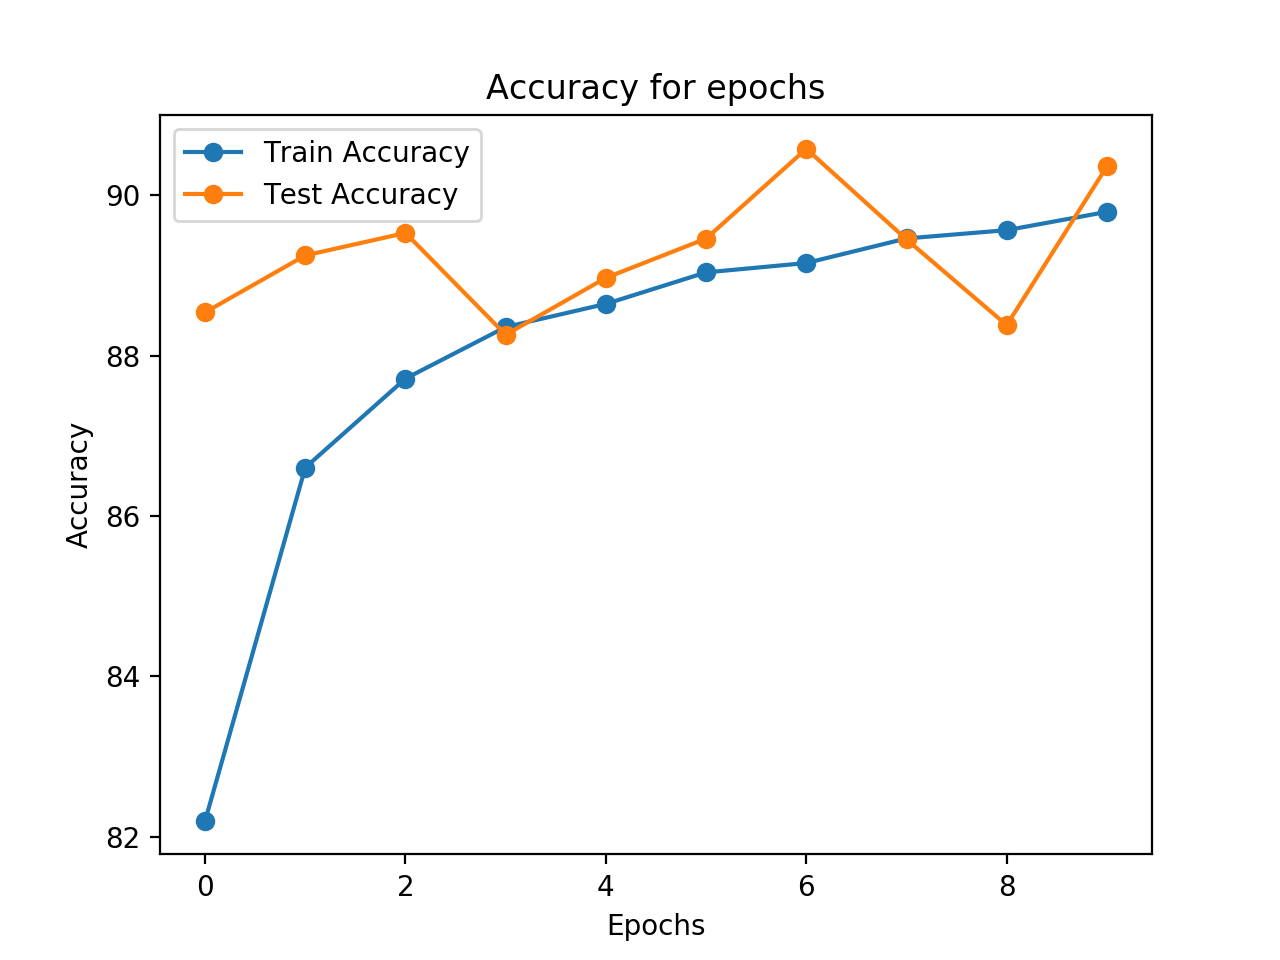

<IPython.core.display.Javascript object>


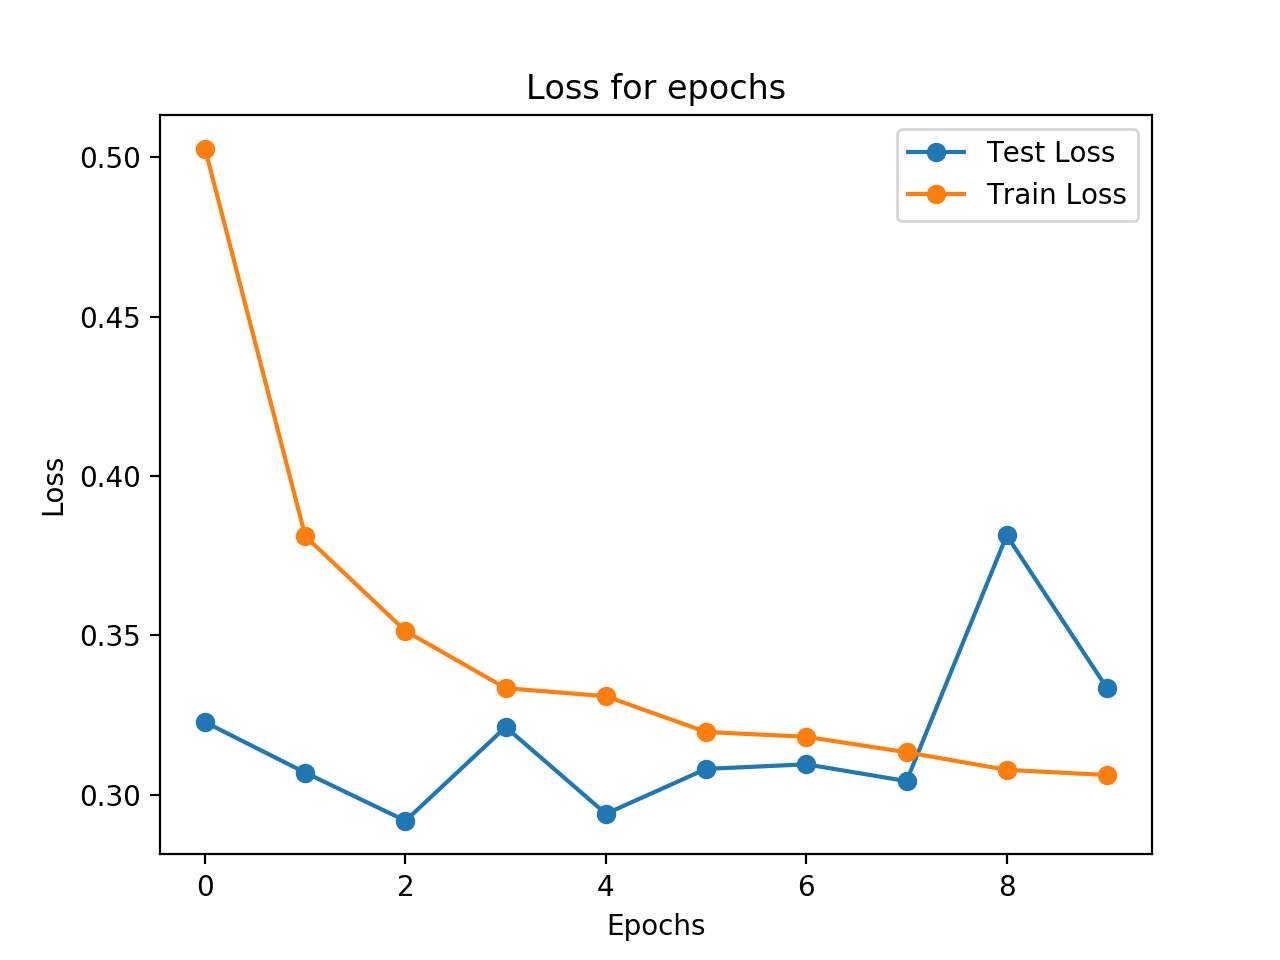

In [12]:
%matplotlib notebook
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for epochs')
plt.legend()

## Fashion MNIST Student Network

In [13]:
temp=7
class Student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,32)
        #self.fc2=nn.Linear(800,800)
        self.fc3=nn.Linear(32,10)
        #self.fc1.weight_orig=self.fc1.weight
        #del self.fc1.weight
        #self.fc2.weight_orig=self.fc2.weight
        #del self.fc2.weight
        #self.fc3.weight_orig=self.fc3.weight
        #del self.fc3.weight
    def forward(self,data):
        x=data.view(-1,28*28)
        #self.fc1.weight=getQuantizedWeights(self.fc1.weight_orig)
        #print(self.fc1.weight)
        x=F.relu(self.fc1(x))
        #self.fc2.weight=getQuantizedWeights(self.fc2.weight_orig)
        #print(self.fc2.weight)
        #x=F.relu(self.fc2(x))
        #self.fc3.weight=getQuantizedWeights(self.fc3.weight_orig)
        x=self.fc3(x)
        return x
def knowledgedistillationloss(outputs,labels,weightTeacher,alpha):
    return nn.KLDivLoss()(F.log_softmax(outputs/temp,dim=1),F.softmax(weightTeacher/temp,dim=1))+alpha*F.cross_entropy(outputs,labels)
'''def knowledgedistillationloss(studentLogits,teacherLogits,minibatchsize):
    return (1/2*minibatchsize)*(studentLogits-teacherLogits)'''
modelStudent=Student()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStudent.cuda()
optimizer=torch.optim.SGD(modelStudent.parameters(),lr=0.01,momentum=0.9)
def trainStudent(trainLoader):
    modelStudent.train()
    modelFashion.eval()
    runningloss=0.0
    correct=0
    total=0
    totalLoss=0
    for i,(data,labels) in enumerate(trainLoader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=modelStudent(data)
        weightTeacher=modelFashion(data)
        weightTeacher=weightTeacher.detach()
        loss=knowledgedistillationloss(predicted,labels,weightTeacher,0.1)
        #print(weightTeacher.shape,predicted.shape,labels.shape)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        #modelStudent.fc1.weight.grad_orig=modelStudent.fc1.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc2.weight.grad_orig=modelStudent.fc2.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc3.weight.grad_orig=modelStudent.fc3.weight.grad
        #del modelStudent.fc1.weight.grad
        #modelStudent.fc1.weight.grad=getQuantizedWeights(modelStudent.fc1.weight.grad_orig)
        #modelStudent.fc2.weight.grad=getQuantizedWeights(modelStudent.fc2.weight.grad_orig)
        #modelStudent.fc3.weight.grad=getQuantizedWeights(modelStudent.fc3.weight.grad_orig)
        optimizer.step()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        totalLoss+=loss.item()
            #print(loss.item())
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return totalLoss/len(trainLoader),(correct/total)*100
                

In [14]:
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        runningLoss=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=modelFashion(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
            runningLoss+=loss.item()
    return runningLoss/len(testLoader),(correct/total)*100

In [15]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=trainStudent(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testStudent(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.1201
epoch 1/10,batch 10000,loss=0.0857
epoch 1/10,batch 15000,loss=0.0751
epoch 2/10,batch 5000,loss=0.0669
epoch 2/10,batch 10000,loss=0.0697
epoch 2/10,batch 15000,loss=0.0652
epoch 3/10,batch 5000,loss=0.0610
epoch 3/10,batch 10000,loss=0.0599
epoch 3/10,batch 15000,loss=0.0614
epoch 4/10,batch 5000,loss=0.0559
epoch 4/10,batch 10000,loss=0.0578
epoch 4/10,batch 15000,loss=0.0561
epoch 5/10,batch 5000,loss=0.0526
epoch 5/10,batch 10000,loss=0.0533
epoch 5/10,batch 15000,loss=0.0532
epoch 6/10,batch 5000,loss=0.0508
epoch 6/10,batch 10000,loss=0.0515
epoch 6/10,batch 15000,loss=0.0511
epoch 7/10,batch 5000,loss=0.0489
epoch 7/10,batch 10000,loss=0.0486
epoch 7/10,batch 15000,loss=0.0500
epoch 8/10,batch 5000,loss=0.0482
epoch 8/10,batch 10000,loss=0.0472
epoch 8/10,batch 15000,loss=0.0473
epoch 9/10,batch 5000,loss=0.0463
epoch 9/10,batch 10000,loss=0.0458
epoch 9/10,batch 15000,loss=0.0469
epoch 10/10,batch 5000,loss=0.0435
epoch 10/10,batch 10000,loss=

In [16]:
print(f'Train accuracy={trainaccuracy[len(testaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=88.105
Test accuracy=85.99


In [17]:
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(f'Total number of parameters of Teacher model is {pytorch_total_params}')
print(f'The total space occupied by this model is {(pytorch_total_params*4)} bytes')

Total number of parameters of Teacher model is 25450
The total space occupied by this model is 101800 bytes


In [18]:
torch.save(modelStudent.state_dict(),'./mnistFashion_student.pth')

<IPython.core.display.Javascript object>


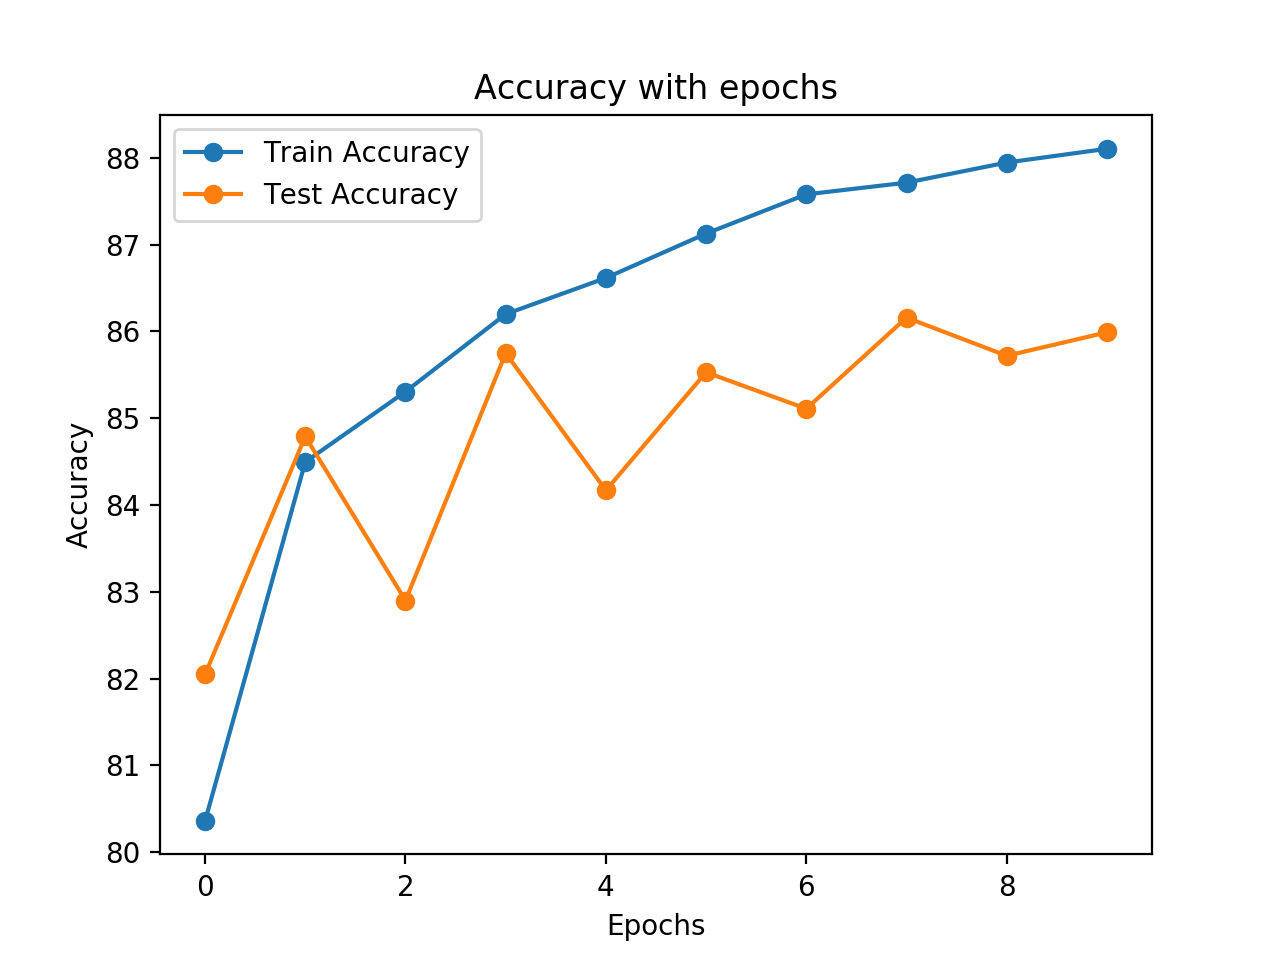

<IPython.core.display.Javascript object>


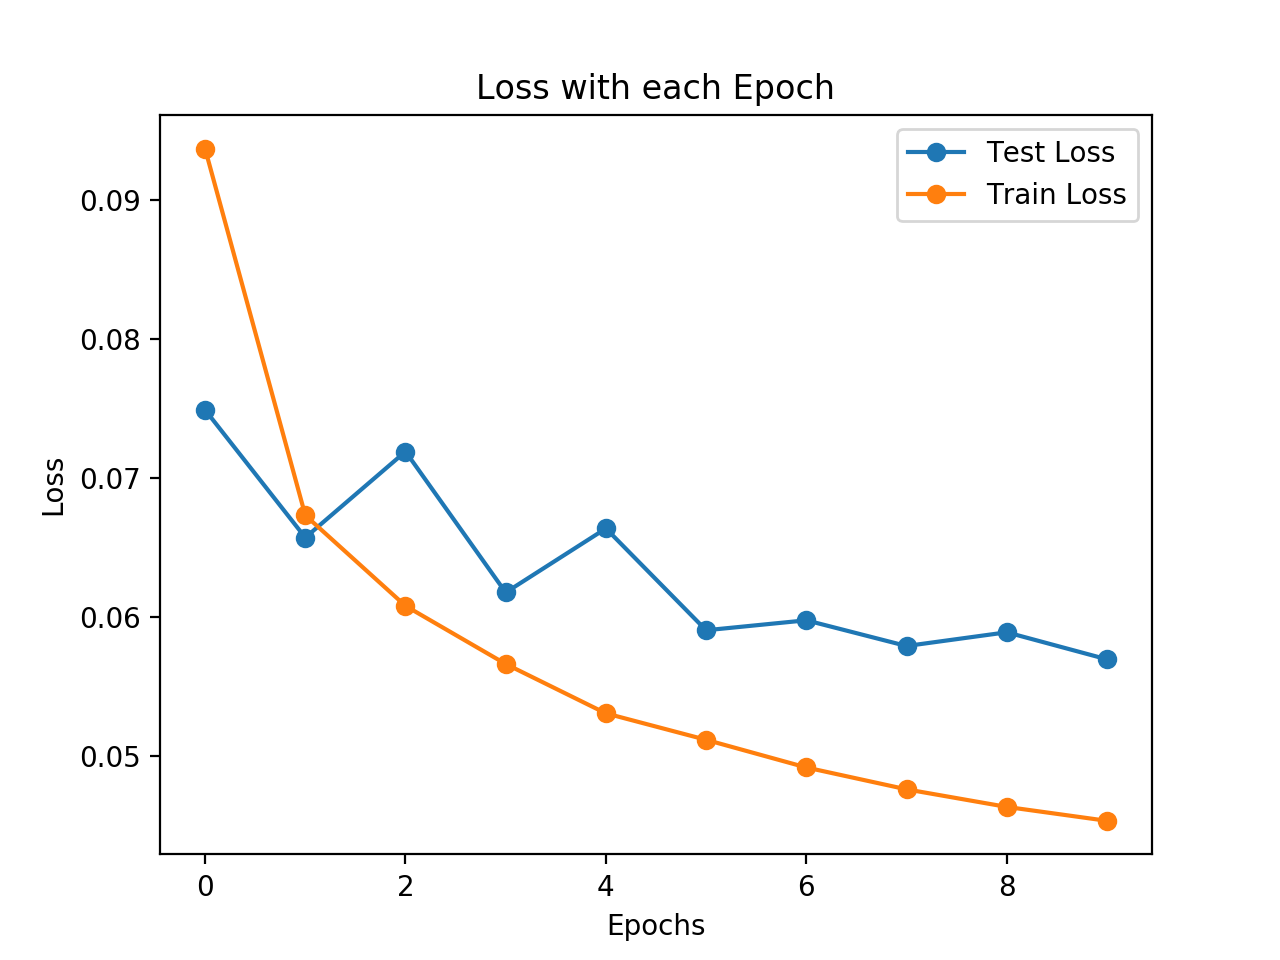

In [19]:
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy with epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with each Epoch')
plt.legend()

In [20]:
def getQuantizedWeights(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0]*weightCopy.shape[1],-1)).reshape(weightCopy.shape[0],weightCopy.shape[1])
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            for j in range(weight.shape[1]):
                weight[i][j]=torch.from_numpy(kmeans.cluster_centers_[labels[i][j]])
        #print(weight)
    return weight
modelStudent.fc1.weight_orig=modelStudent.fc1.weight
#print(modelStudent.fc1.weight_orig)
#del modelStudent.fc1.weight
#modelStudent.fc2.weight_orig=modelStudent.fc2.weight
#del modelStudent.fc2.weight
modelStudent.fc3.weight_orig=modelStudent.fc3.weight
#del modelStudent.fc3.weight
modelStudent.fc1.weight=getQuantizedWeights(modelStudent.fc1.weight_orig,10)
#modelStudent.fc2.weight=getQuantizedWeights(modelStudent.fc2.weight_orig,10)
modelStudent.fc3.weight=getQuantizedWeights(modelStudent.fc3.weight_orig,10)

In [21]:
def getQuantizedWeightsBias(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        #print(weightCopy.view(weightCopy.shape[0],-1).shape)
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0],-1))
        #print(labels)
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            weight[i]=torch.from_numpy(kmeans.cluster_centers_[labels[i]])
    return weight
modelStudent.fc1.bias_orig=modelStudent.fc1.bias
#print(modelStudent.fc1.bias_orig)
#del modelStudent.fc1.bias
#modelStudent.fc2.bias_orig=modelStudent.fc2.bias
#del modelStudent.fc2.weight
modelStudent.fc3.bias_orig=modelStudent.fc3.bias
#del modelStudent.fc3.bias
#print(getQuantizedWeightsBias(modelStudent.fc1.bias_orig,4))
modelStudent.fc1.bias=getQuantizedWeightsBias(modelStudent.fc1.bias_orig,4)
#modelStudent.fc2.bias=getQuantizedWeightsBias(modelStudent.fc2.bias_orig,4)
modelStudent.fc3.bias=getQuantizedWeightsBias(modelStudent.fc3.bias_orig,4)
#print(modelStudent.fc1.bias)

In [22]:
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=modelStudent(data)
            weightTeacher=modelFashion(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderFashionMNIST)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=8401.0,accuracy=84.00999999999999


In [24]:
pytorch_total_params = sum(p.numel() for p in modelStudent.parameters())
print(pytorch_total_params)
additional_storage=(2*32*10)+(2*4*32)
print(f'Total size of the file is {(pytorch_total_params/2)+(additional_storage/8)} bytes')

25450
Total size of the file is 12837.0 bytes


## Standalone Student Network

In [7]:
class StandaloneStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(28*28,1200)
        
        self.fc3=nn.Linear(1200,10)
       
    def forward(self,data):
        x=data.view(-1,28*28)

        x=F.relu(self.fc1(x))
        
        x=self.fc3(x)
        return x
modelStandaloneStudentFashion=StandaloneStudent()
use_cuda=True
if use_cuda and torch.cuda.is_available():
    modelStandaloneStudentFashion.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(modelStandaloneStudentFashion.parameters(),lr=0.01,momentum=0.9)
def train(loader):
    modelStandaloneStudentFashion.train()
    runningloss=0.0
    correct=0.0
    total=0.0
    runninglosstotal=0.0
    for i,(image,labels) in enumerate(loader):
        if use_cuda and torch.cuda.is_available():
            image=image.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        prediction=modelStandaloneStudentFashion(image)
        loss=criterion(prediction,labels)
        loss.backward()
        optimizer.step()
        runningloss+=loss.item()
        runninglosstotal+=loss.item()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==labels).sum().item()
        total+=image.shape[0]
        if i%5000==4999:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/5000:.4f}')
            runningloss=0.0
    return runninglosstotal/len(loader),(correct/total)*100

In [8]:
def testMNIST(loader):
    with torch.no_grad():
        modelStandaloneStudentFashion.eval()
        correct=0
        total=0
        runningLoss=0
        for i,(image,labels) in enumerate(loader):
            if use_cuda and torch.cuda.is_available():
                image=image.cuda()
                labels=labels.cuda()
            prediction=modelStandaloneStudentFashion(image)
            loss=criterion(prediction,labels)
            runningLoss+=loss.item()
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=labels.shape[0]
    return runningLoss/len(loader),(correct/total)*100

In [9]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=10
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderFashionMNIST)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testMNIST(testLoaderFashionMNIST)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/10,batch 5000,loss=0.9864
epoch 1/10,batch 10000,loss=0.9691
epoch 1/10,batch 15000,loss=0.9807
epoch 2/10,batch 5000,loss=0.9647
epoch 2/10,batch 10000,loss=0.9648
epoch 2/10,batch 15000,loss=0.9457
epoch 3/10,batch 5000,loss=0.9728
epoch 3/10,batch 10000,loss=0.9015
epoch 3/10,batch 15000,loss=0.9260
epoch 4/10,batch 5000,loss=0.9323
epoch 4/10,batch 10000,loss=0.9580
epoch 4/10,batch 15000,loss=0.9618
epoch 5/10,batch 5000,loss=0.9311
epoch 5/10,batch 10000,loss=0.9910
epoch 5/10,batch 15000,loss=0.9968
epoch 6/10,batch 5000,loss=0.9632
epoch 6/10,batch 10000,loss=1.1507
epoch 6/10,batch 15000,loss=1.0643
epoch 7/10,batch 5000,loss=1.0682
epoch 7/10,batch 10000,loss=1.0486
epoch 7/10,batch 15000,loss=1.1065
epoch 8/10,batch 5000,loss=1.0901
epoch 8/10,batch 10000,loss=0.9978
epoch 8/10,batch 15000,loss=0.9736
epoch 9/10,batch 5000,loss=0.9042
epoch 9/10,batch 10000,loss=0.9790
epoch 9/10,batch 15000,loss=0.9801
epoch 10/10,batch 5000,loss=0.9002
epoch 10/10,batch 10000,loss=

In [10]:
print(f'Train accuracy={trainaccuracy[len(testaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=72.39833333333333
Test accuracy=67.46


## CIFAR 10 Teacher Network

In [2]:
trainSetCifar=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
testSetCifar=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainLoaderCifar=DataLoader(dataset=trainSetCifar,batch_size=32,shuffle=True)
testLoaderCifar=DataLoader(dataset=testSetCifar,batch_size=32,shuffle=False)

In [4]:
vgg=models.vgg16(pretrained=True)

In [5]:
use_cuda=True
if use_cuda and torch.cuda.is_available():
    vgg.cuda()
vgg.classifier[6]=nn.Sequential(nn.Linear(4096,10))
for param in vgg.features.parameters():
    param.requires_grad=False
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
if use_cuda and torch.cuda.is_available():
    vgg.cuda()
epochs=15
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(vgg.classifier.parameters(),lr=0.001,momentum=0.9)
def trainCifar(loader):
    vgg.train()
    correct=0
    total=0
    runningloss=0
    totalLoss=0.0
    for i,(data,label) in enumerate(loader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            label=label.cuda()
        optimizer.zero_grad()
        prediction=vgg(data)
        loss=criterion(prediction,label)
        loss.backward()
        optimizer.step()
        prediction=F.log_softmax(prediction)
        _,index=torch.max(prediction.data,1)
        correct+=(index==label).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        totalLoss+=loss.item()
        if i%500==499:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/500}')
            runningloss=0.0
    return totalLoss/len(loader),(correct/total)*100

In [7]:
def testCifar(loader):
    vgg.eval()
    with torch.no_grad():
        correct=0
        total=0
        runningLoss=0.0
        for i,(data,label) in enumerate(loader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                label=label.cuda()
            prediction=vgg(data)
            loss=criterion(prediction,label)
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==label).sum().item()
            total+=data.shape[0]
            runningLoss+=loss.item()
    return runningLoss/len(loader),(correct/total)*100

In [8]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=15
for epoch in range(epochs):
    loss,accuracy=trainCifar(trainLoaderCifar)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=testCifar(testLoaderCifar)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/15,batch 500,loss=0.8737270167469978
epoch 1/15,batch 1000,loss=0.6082279133498669
epoch 1/15,batch 1500,loss=0.5592522157132626
epoch 2/15,batch 500,loss=0.4728390459567308
epoch 2/15,batch 1000,loss=0.4462856734395027
epoch 2/15,batch 1500,loss=0.42883283393085003
epoch 3/15,batch 500,loss=0.36167111195623874
epoch 3/15,batch 1000,loss=0.369134242773056
epoch 3/15,batch 1500,loss=0.3500366696417332
epoch 4/15,batch 500,loss=0.2980898850858211
epoch 4/15,batch 1000,loss=0.2884804695099592
epoch 4/15,batch 1500,loss=0.28618369716405867
epoch 5/15,batch 500,loss=0.23367438066005708
epoch 5/15,batch 1000,loss=0.22865311627089976
epoch 5/15,batch 1500,loss=0.22677634920179843
epoch 6/15,batch 500,loss=0.17564621809124947
epoch 6/15,batch 1000,loss=0.17449259687960147
epoch 6/15,batch 1500,loss=0.18091975942254065
epoch 7/15,batch 500,loss=0.13586344832181932
epoch 7/15,batch 1000,loss=0.13369079588353633
epoch 7/15,batch 1500,loss=0.13477863231301307
epoch 8/15,batch 500,loss=0.09

In [9]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=99.564
Test accuracy=88.0


In [16]:
print(trainloss,testloss)

[0.6496261358261108, 0.33786246180534363, 0.47268861532211304, 0.2339382916688919, 0.3048306703567505, 0.05433249473571777, 0.0983114242553711, 0.021552622318267822, 0.01011502742767334, 0.04940098524093628, 0.0025367140769958496, 0.045069873332977295, 0.012764215469360352, 0.008210957050323486, 0.001629471778869629] [0.6592537760734558, 0.48231878876686096, 0.5973474979400635, 0.5536191463470459, 0.5697293281555176, 0.5896790027618408, 0.5706871747970581, 0.5544676780700684, 0.711677610874176, 0.6222238540649414, 0.6645213961601257, 0.7568644285202026, 0.6674511432647705, 0.5727331638336182, 0.7072399258613586]


In [10]:
pytorch_total_params = sum(p.numel() for p in vgg.parameters())
print(f'The Total number of parameters of the Teacher Model is {pytorch_total_params}')
#additional_storage=(3*16*10)+(3*4*16)
print(f'Total size of the file is {pytorch_total_params*4} bytes')

The Total number of parameters of the Teacher Model is 134301514
Total size of the file is 537206056 bytes


<IPython.core.display.Javascript object>


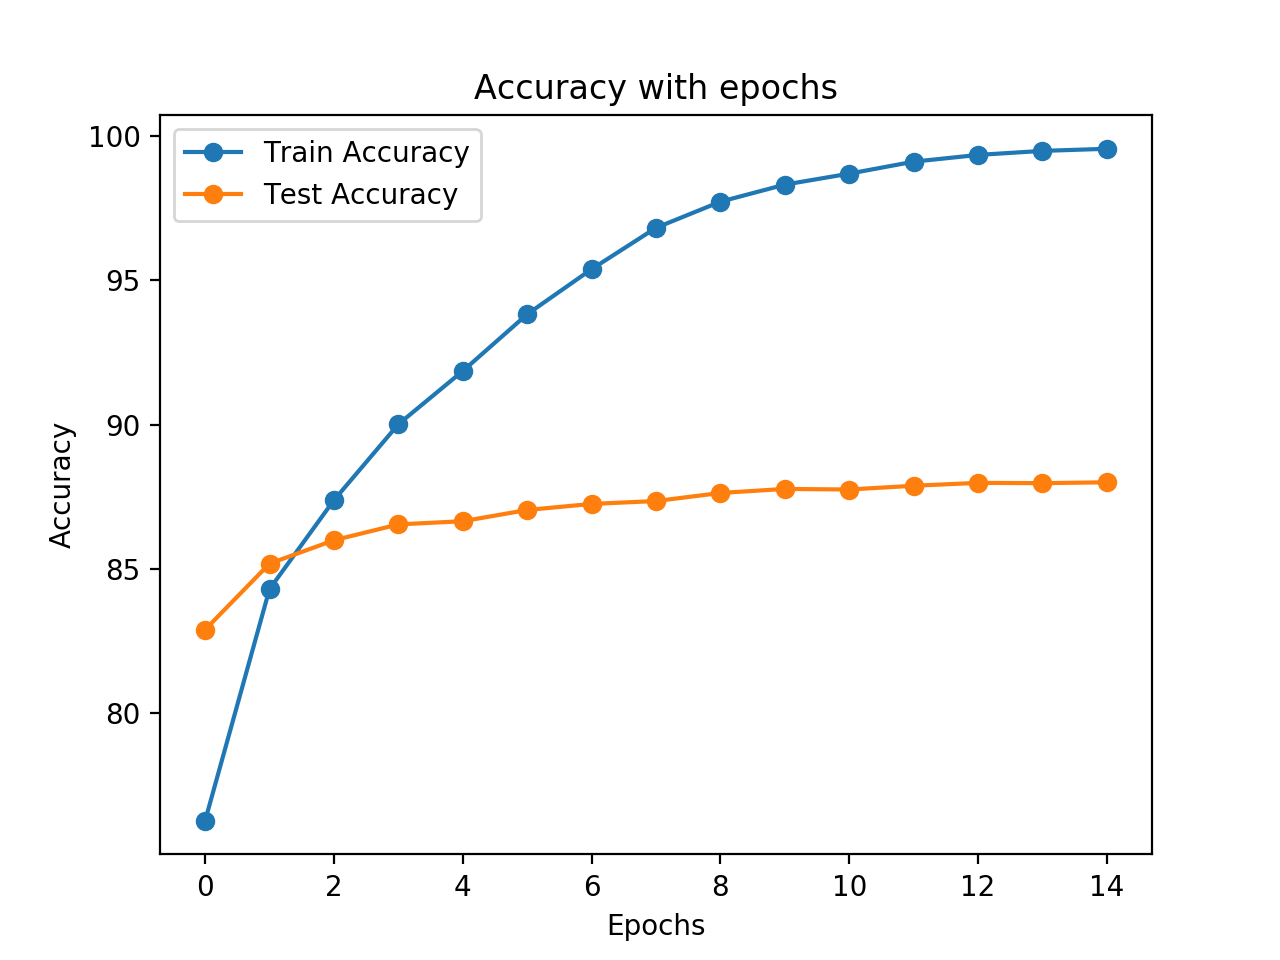

<IPython.core.display.Javascript object>


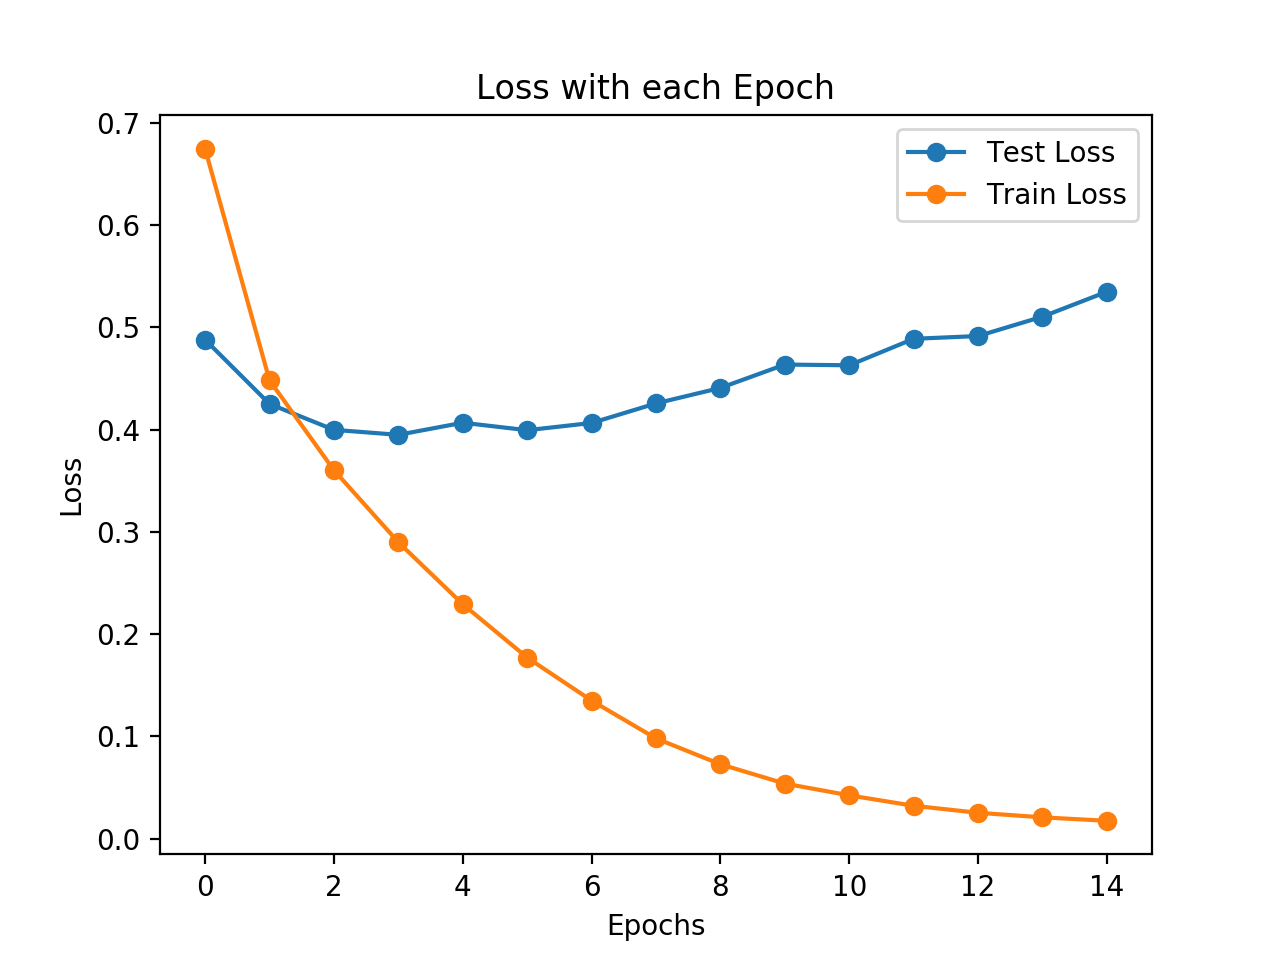

In [12]:
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy with epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with each Epoch')
plt.legend()

## CIFAR 10 Student Network

In [17]:
alexNet=models.alexnet()
alexNet.classifier[6]=nn.Sequential(nn.Linear(4096,10))
print(alexNet)
for param in alexNet.parameters():
    param.requires_grad=True

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
epochs=20
temp=7
def knowledgedistillationloss(outputs,labels,weightTeacher,alpha):
    return nn.KLDivLoss()(F.log_softmax(outputs/temp,dim=1),F.softmax(weightTeacher/temp,dim=1))+alpha*F.cross_entropy(outputs,labels)
if use_cuda and torch.cuda.is_available():
    alexNet.cuda()
optimizer=torch.optim.SGD(alexNet.parameters(),lr=0.01,momentum=0.9)
def train(loader):
    alexNet.train()
    vgg.eval()
    runningloss=0.0
    correct=0
    total=0
    for i,(data,labels) in enumerate(loader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=alexNet(data)
        weightTeacher=vgg(data)
        weightTeacher=weightTeacher.detach()
        #print(weightTeacher.shape,predicted.shape,labels.shape)
        loss=knowledgedistillationloss(predicted,labels,weightTeacher,0.1)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        optimizer.step()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        #print(loss.item())
        if i%500==499:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/500:.4f}')
            runningloss=0.0
    return loss.item(),(correct/total)*100
                

In [25]:
def test(loader):
    alexNet.eval()
    vgg.eval()
    with torch.no_grad():
        correct=0
        total=0
        for i,(data,label) in enumerate(loader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                label=label.cuda()
            prediction=alexNet(data)
            weightTeacher=vgg(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,label,weightTeacher,0.1)
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==label).sum().item()
            total+=data.shape[0]
    return loss.item(),(correct/total)*100




In [27]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=20
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderCifar)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=test(testLoaderCifar)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/20,batch 500,loss=0.3193
epoch 1/20,batch 1000,loss=0.3175
epoch 1/20,batch 1500,loss=0.2987
epoch 2/20,batch 500,loss=0.2783
epoch 2/20,batch 1000,loss=0.2601
epoch 2/20,batch 1500,loss=0.2442
epoch 3/20,batch 500,loss=0.2274
epoch 3/20,batch 1000,loss=0.2197
epoch 3/20,batch 1500,loss=0.2120
epoch 4/20,batch 500,loss=0.2021
epoch 4/20,batch 1000,loss=0.1931
epoch 4/20,batch 1500,loss=0.1867
epoch 5/20,batch 500,loss=0.1776
epoch 5/20,batch 1000,loss=0.1715
epoch 5/20,batch 1500,loss=0.1675
epoch 6/20,batch 500,loss=0.1581
epoch 6/20,batch 1000,loss=0.1486
epoch 6/20,batch 1500,loss=0.1453
epoch 7/20,batch 500,loss=0.1376
epoch 7/20,batch 1000,loss=0.1357
epoch 7/20,batch 1500,loss=0.1292
epoch 8/20,batch 500,loss=0.1213
epoch 8/20,batch 1000,loss=0.1192
epoch 8/20,batch 1500,loss=0.1172
epoch 9/20,batch 500,loss=0.1113
epoch 9/20,batch 1000,loss=0.1083
epoch 9/20,batch 1500,loss=0.1062
epoch 10/20,batch 500,loss=0.0992
epoch 10/20,batch 1000,loss=0.0967
epoch 10/20,batch 1500

In [28]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

accuracy=84.03


<IPython.core.display.Javascript object>


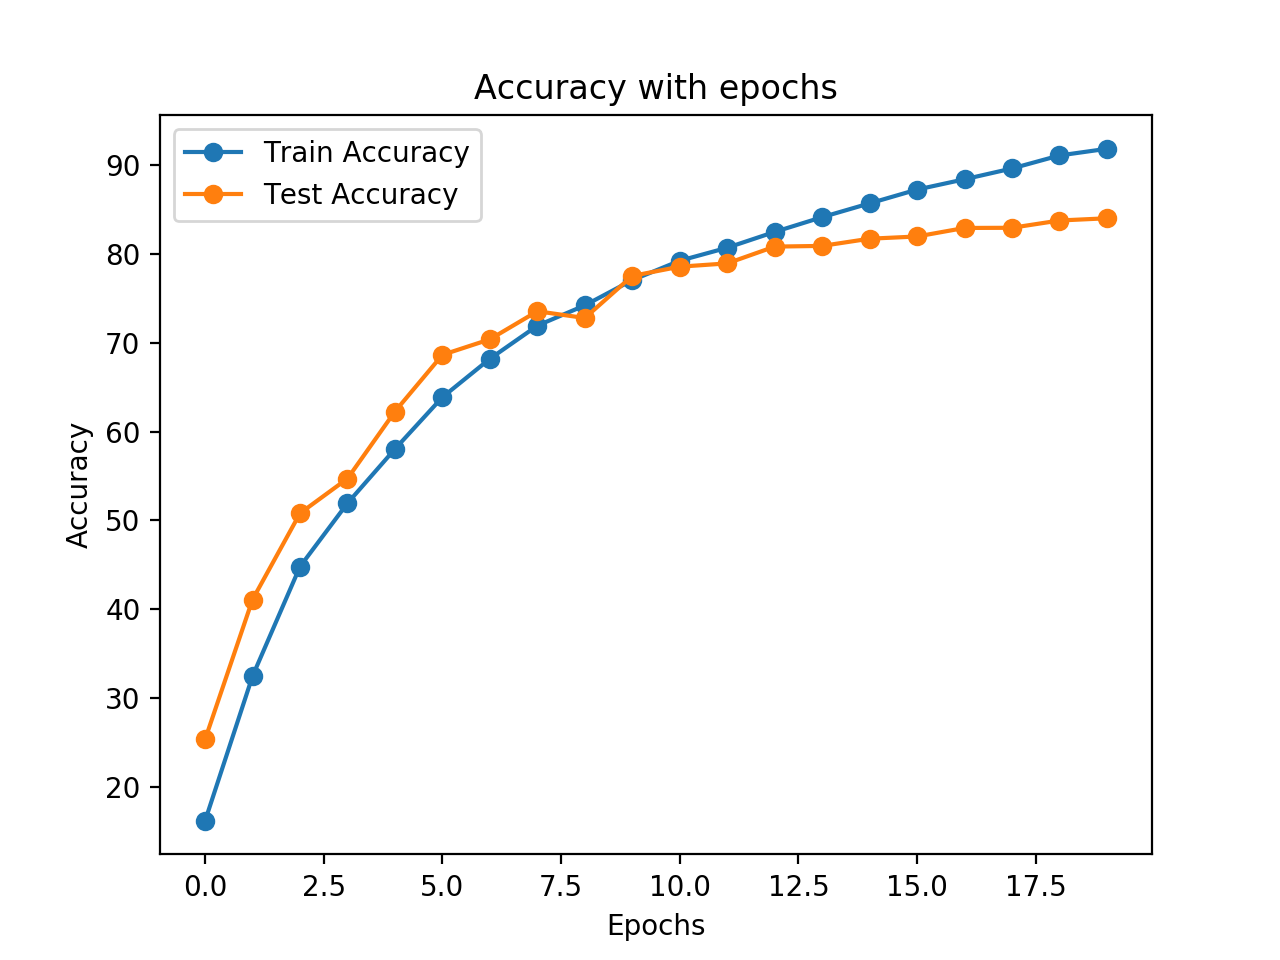

<IPython.core.display.Javascript object>


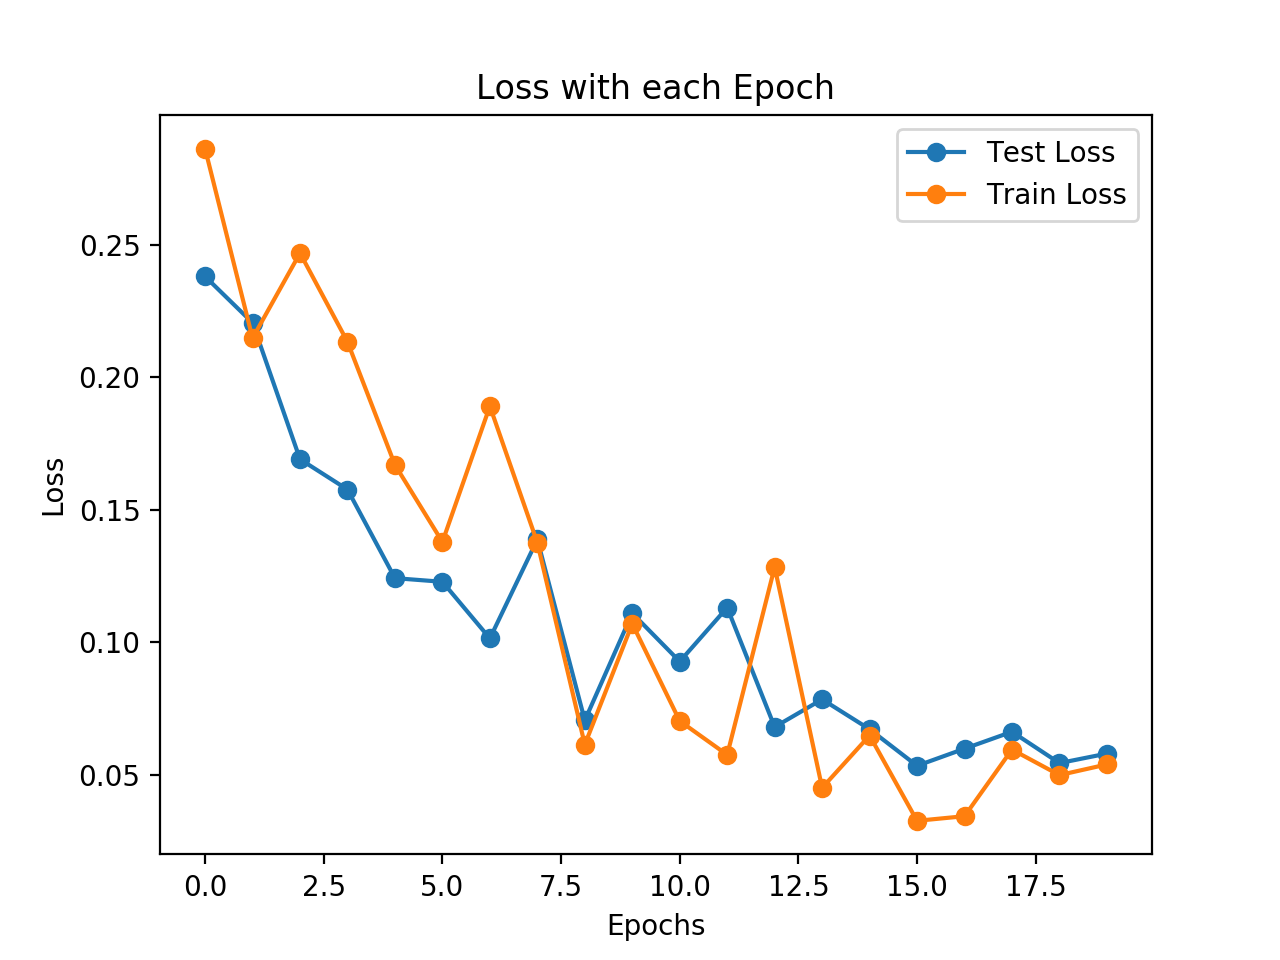

In [29]:
plt.figure()
plt.plot(trainaccuracy,label='Train Accuracy',marker='o')
plt.plot(testaccuracy,label='Test Accuracy',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy with epochs')
plt.legend()
plt.figure()
plt.plot(testloss,label='Test Loss',marker='o')
plt.plot(trainloss,label='Train Loss',marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with each Epoch')
plt.legend()

In [15]:
pytorch_total_params = sum(p.numel() for p in alexNet.parameters())
print(f'The total number of Parameters of the Student model before Quantizatoion is {pytorch_total_params}')
#additional_storage=(3*32*10)+(3*32*4)
#print(f'Total size of the file is {(pytorch_total_params/2)+(additional_storage/8)} bytes')
print(f'Total size of the file is {(pytorch_total_params*4)} bytes')

The total number of Parameters of the Student model before Quantizatoion is 57044810
Total size of the file is 228179240 bytes


In [16]:
def getQuantizedWeights(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0]*weightCopy.shape[1],-1)).reshape(weightCopy.shape[0],weightCopy.shape[1])
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            for j in range(weight.shape[1]):
                weight[i][j]=torch.from_numpy(kmeans.cluster_centers_[labels[i][j]])
        #print(weight)
    return weight
alexNet.classifier[1].weight=getQuantizedWeights(alexNet.classifier[1].weight,10)
#print(new_models.classifier[1].weight)
alexNet.classifier[4].weight=getQuantizedWeights(alexNet.classifier[4].weight,10)
alexNet.classifier[6][0].weight=getQuantizedWeights(alexNet.classifier[6][0].weight,10)

In [17]:
def getQuantizedWeightsBias(weight,nClusters):
    with torch.no_grad():
        weightCopy=weight.detach().cpu()
        #print(weight)
        minValue=torch.min(weightCopy)
        maxValue=torch.max(weightCopy)
        initialization=np.linspace(minValue,maxValue,nClusters)
        kmeans=KMeans(n_clusters=nClusters,init=initialization.reshape(-1,1))
        #print(weightCopy.view(weightCopy.shape[0],-1).shape)
        labels=kmeans.fit_predict(weightCopy.view(weightCopy.shape[0],-1))
        #print(labels)
        #print(kmeans.cluster_centers_)
        for i in range(weight.shape[0]):
            weight[i]=torch.from_numpy(kmeans.cluster_centers_[labels[i]])
    return weight

alexNet.classifier[1].bias=getQuantizedWeightsBias(alexNet.classifier[1].bias,4)
#print(new_models.classifier[1].weight)
alexNet.classifier[4].bias=getQuantizedWeightsBias(alexNet.classifier[4].bias,4)
alexNet.classifier[6][0].bias=getQuantizedWeightsBias(alexNet.classifier[6][0].bias,4)

In [20]:
def testStudent(testLoader):
    with torch.no_grad():
        correct=0.0
        total=0.0
        for i,(data,labels) in enumerate(testLoader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                labels=labels.cuda()
            prediction=alexNet(data)
            weightTeacher=vgg(data)
            weightTeacher=weightTeacher.detach()
            loss=knowledgedistillationloss(prediction,labels,weightTeacher,0.1)
            predicition=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==labels).sum().item()
            total+=data.shape[0]
    return correct,(correct/total)*100
correct,accuracy=testStudent(testLoaderCifar)
print(f'correctly classified={correct},accuracy={accuracy}')

correctly classified=8387.0,accuracy=83.87


In [23]:
pytorch_total_params_features = sum(p.numel() for p in alexNet.features.parameters())
#print(pytorch_total_params_features)
pytorch_total_params_classifier = sum(p.numel() for p in alexNet.classifier.parameters())
#print(pytorch_total_params_classifier)
#print(pytorch_total_params_classifier+pytorch_total_params_features)
additional_storage=(3*32*10)+(3*32*4)
print(f'Total Size of the file with Quantization and Knowledge Distillation is {(pytorch_total_params_features*4)+(pytorch_total_params_classifier/2)+(additional_storage)}')

Total Size of the file is 37167685.0


## Standalone Student

In [4]:
alexNet=models.alexnet()
alexNet.classifier[6]=nn.Sequential(nn.Linear(4096,10))
print(alexNet)
for param in alexNet.parameters():
    param.requires_grad=True

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
use_cuda=True
if use_cuda and torch.cuda.is_available():
    alexNet.cuda()
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(alexNet.parameters(),lr=0.01,momentum=0.9)
def train(loader):
    alexNet.train()
    runningloss=0.0
    correct=0
    total=0
    for i,(data,labels) in enumerate(loader):
        if use_cuda and torch.cuda.is_available():
            data=data.cuda()
            labels=labels.cuda()
        optimizer.zero_grad()
        predicted=alexNet(data)
       
        loss=criterion(predicted,labels)
        #loss=knowledgedistillationloss(predicted,weightTeacher,10000)
        loss.backward()
        optimizer.step()
        predicted=F.log_softmax(predicted)
        _,index=torch.max(predicted.data,1)
        correct+=(index==labels).sum().item()
        total+=data.shape[0]
        runningloss+=loss.item()
        #print(loss.item())
        if i%500==499:
            print(f'epoch {epoch+1}/{epochs},batch {i+1},loss={runningloss/500:.4f}')
            runningloss=0.0
    return loss.item(),(correct/total)*100
                

In [9]:
def test(loader):
    alexNet.eval()
    with torch.no_grad():
        correct=0
        total=0
        for i,(data,label) in enumerate(loader):
            if use_cuda and torch.cuda.is_available():
                data=data.cuda()
                label=label.cuda()
            prediction=alexNet(data)
            loss=criterion(prediction,label)
            prediction=F.log_softmax(prediction)
            _,index=torch.max(prediction.data,1)
            correct+=(index==label).sum().item()
            total+=data.shape[0]
    return loss.item(),(correct/total)*100

In [10]:
trainloss=list()
testloss=list()
trainaccuracy=list()
testaccuracy=list()
epochs=20
for epoch in range(epochs):
    loss,accuracy=train(trainLoaderCifar)
    trainloss.append(loss)
    trainaccuracy.append(accuracy)
    loss,accuracy=test(testLoaderCifar)
    testloss.append(loss)
    testaccuracy.append(accuracy)

epoch 1/20,batch 500,loss=1.3071
epoch 1/20,batch 1000,loss=1.1575
epoch 1/20,batch 1500,loss=1.0547
epoch 2/20,batch 500,loss=0.9512
epoch 2/20,batch 1000,loss=0.9056
epoch 2/20,batch 1500,loss=0.8731
epoch 3/20,batch 500,loss=0.7802
epoch 3/20,batch 1000,loss=0.7591
epoch 3/20,batch 1500,loss=0.7546
epoch 4/20,batch 500,loss=0.6515
epoch 4/20,batch 1000,loss=0.6734
epoch 4/20,batch 1500,loss=0.6703
epoch 5/20,batch 500,loss=0.5813
epoch 5/20,batch 1000,loss=0.5856
epoch 5/20,batch 1500,loss=0.5875
epoch 6/20,batch 500,loss=0.4970
epoch 6/20,batch 1000,loss=0.5216
epoch 6/20,batch 1500,loss=0.5374
epoch 7/20,batch 500,loss=0.4378
epoch 7/20,batch 1000,loss=0.4688
epoch 7/20,batch 1500,loss=0.4859
epoch 8/20,batch 500,loss=0.3991
epoch 8/20,batch 1000,loss=0.4237
epoch 8/20,batch 1500,loss=0.4447
epoch 9/20,batch 500,loss=0.3608
epoch 9/20,batch 1000,loss=0.3875
epoch 9/20,batch 1500,loss=0.4079
epoch 10/20,batch 500,loss=0.3356
epoch 10/20,batch 1000,loss=0.3643
epoch 10/20,batch 1500

In [11]:
print(f'Train accuracy={trainaccuracy[len(trainaccuracy)-1]}')
print(f'Test accuracy={testaccuracy[len(testaccuracy)-1]}')

Train accuracy=87.30799999999999
Test accuracy=77.79
